# Máy học nâng cao - Lab 08
# Họ tên: Nguyễn Phú Thành - MSSV: 18110014

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt

In [2]:
batch_size = 128
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
labels = np.concatenate([y_train,y_test])
all_digits = (all_digits.astype("float32")-127.5)/127.5
all_digits = np.reshape(all_digits,(-1,28,28,1))
all_digits = tf.data.Dataset.from_tensor_slices(all_digits)

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(np.reshape(np.array(range(0,10)),[-1,1]))
onehot_encoded = onehot_encoder.transform(np.reshape(labels,[-1,1]))
all_labels = tf.data.Dataset.from_tensor_slices(onehot_encoded)

dataset = tf.data.Dataset.zip((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size = 1024).batch(batch_size).prefetch(32)

# Bài tập
1. Dựa vào mô hình CGAN ở trên ở viết mô hình CGAN như ở phần dưới
2. Trong quá trình training hãy in ra các số sau 3, 5, 7, 9

In [4]:
# Set global random seed
tf.random.set_seed(0)

In [5]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator 
        self.generator = generator
        self.latent_dim = latent_dim
    def compile(self, d_optimizer, g_optimizer, loss_function):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_function = loss_function 
    def train_step(self, real_images):
        # tạo batch size từ dữ liệu đầu vào
        batch_size = tf.shape(real_images[0])[0]
        CLabel = real_images[1]
        random_latent_vectors = tf.random.normal(shape = (batch_size, self.latent_dim))

        # Tạo ra ảnh giả từ mạng generator
        generated_images = self.generator([random_latent_vectors, CLabel])

        # nối ảnh giả và ảnh thật làm bộ dữ liệu cho mô hình discriminator
        combined_images = tf.concat([generated_images, real_images[0]], axis=0)
        combined_CLabel = tf.concat([CLabel, CLabel], axis=0)
        # Ở đây đánh nhãn ảnh giả là 1, ảnh thật là 0
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # trick để add thêm noise cho nhãn
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # huấn luyện discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_CLabel]) #Dự đoán 
            d_loss = self.loss_function(labels, predictions)  #Đưa kết quả dự đoán và grouth-truth vào hàm loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        ) #cập nhật weights cho mô hình discrimunator


        # lặp lại bước tạo noise như ở trên
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # tạo mộ bộ nhãn sao cho đều là 0 để đánh lừa discriminator
        misleading_labels = tf.zeros((batch_size, 1))

        # Train generator (lưu ý k update weights cho discriminator)
        with tf.GradientTape() as tape:
            predictions = self.discriminator([self.generator([random_latent_vectors, CLabel]), CLabel])
            g_loss = self.loss_function(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [6]:
class ConditionalGANMonitor(keras.callbacks.Callback):
    def __init__(self, labels, num_classes = 10, latent_dim = 100):
        self.labels = labels
        self.num_img = len(labels)
        self.num_classes = num_classes
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape = (self.num_img, self.latent_dim))
        one_hot_labels = np.zeros((self.num_img, self.num_classes), dtype = np.uint8)
        for i, label in enumerate(self.labels):
            one_hot_labels[i, label] = 1
        
        one_hot_labels = tf.convert_to_tensor(one_hot_labels)
        generated_images = self.model.generator([random_latent_vectors, one_hot_labels])
        generated_images = generated_images*127.5 + 127.5
        plt.close("all")
        print(f">> Images generated in epoch = {epoch + 1}:")
        fig, axes = plt.subplots(nrows = 1, ncols = self.num_img, figsize = (10, self.num_img))
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            axes[i].imshow(img, cmap = plt.cm.gray)
            _ = axes[i].set(xticks = [], yticks = [])
        plt.show()

In [7]:
# Generator
latent_dim, num_classes = 100, 10
input_gen = tf.keras.layers.Input(shape = (latent_dim,))
labels_gen =  tf.keras.layers.Input(shape = (10,))
dense_gen_1 = tf.keras.layers.Dense(units = 7*7*256, use_bias = False)(input_gen)
dense_label_gen_1 = tf.keras.layers.Dense(units = 7*7)(labels_gen)
reshape_gen_1 = tf.keras.layers.Reshape((7, 7, 256))(dense_gen_1)
reshape_label_gen_1 = tf.keras.layers.Reshape((7, 7, 1))(dense_label_gen_1)
concatenate_gen = tf.keras.layers.Concatenate()([reshape_gen_1, reshape_label_gen_1])
batch_norm_gen_1 = tf.keras.layers.BatchNormalization()(concatenate_gen)
conv_t1_gen = tf.keras.layers.Convolution2DTranspose(
    filters = 128, 
    kernel_size = (5, 5), 
    strides = (1, 1),
    padding = "same",
    use_bias = False
)(batch_norm_gen_1)
batch_norm_gen_2 = tf.keras.layers.BatchNormalization()(conv_t1_gen)
lrelu_1_gen = tf.keras.layers.LeakyReLU(alpha = 0.2)(batch_norm_gen_2)
conv_t2_gen = tf.keras.layers.Convolution2DTranspose(
    filters = 64, 
    kernel_size = (5, 5), 
    strides = (2, 2),
    padding = "same",
    use_bias = False
)(lrelu_1_gen)
batch_norm_gen_3 = tf.keras.layers.BatchNormalization()(conv_t2_gen)
lrelu_2_gen = tf.keras.layers.LeakyReLU(alpha = 0.2)(batch_norm_gen_3)
conv_t3_gen = tf.keras.layers.Convolution2DTranspose(
    filters = 1, 
    kernel_size = (5, 5), 
    strides = (2, 2),
    padding = "same",
    use_bias = False,
    activation = "tanh"
)(lrelu_2_gen)
reshape_gen = tf.keras.layers.Reshape((28, 28, 1))(conv_t3_gen)

generator = tf.keras.models.Model(inputs = (input_gen, labels_gen), outputs = reshape_gen)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 12544)        1254400     ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 49)           539         ['input_2[0][0]']                
                                                                                              

In [8]:
# Discriminator
labels_dis = tf.keras.layers.Input(shape = (num_classes,))
dense_label_dis_1 = tf.keras.layers.Dense(units = 28 * 28)(labels_dis)
input_dis = tf.keras.layers.Input(shape = (28, 28, 1))
reshape_label_dis_1 = tf.keras.layers.Reshape((28, 28, 1))(dense_label_dis_1)
concatenate_dis = tf.keras.layers.Concatenate()([input_dis, reshape_label_dis_1])
conv2d_dis_1 = tf.keras.layers.Convolution2D(
    filters = 64,
    kernel_size = (5, 5),
    strides = (2, 2),
    padding = "same"
)(concatenate_dis)
lrelu_dis_1 = tf.keras.layers.LeakyReLU(alpha = 0.2)(conv2d_dis_1)
conv2d_dis_2 = tf.keras.layers.Convolution2D(
    filters = 128,
    kernel_size = (5, 5),
    strides = (2, 2),
    padding = "same"
)(lrelu_dis_1)
lrelu_dis_2 = tf.keras.layers.LeakyReLU(alpha = 0.2)(conv2d_dis_2)
flatten = tf.keras.layers.Flatten()(lrelu_dis_2)
dense = tf.keras.layers.Dense(units = 1, activation = "sigmoid")(flatten)

discriminator = tf.keras.models.Model(inputs = (input_dis, labels_dis), outputs = dense)
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 784)          8624        ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 reshape_3 (Reshape)            (None, 28, 28, 1)    0           ['dense_2[0][0]']                
                                                                                            

>> Images generated in epoch = 1:


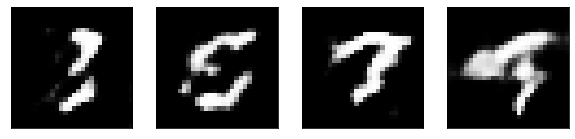

>> Images generated in epoch = 2:


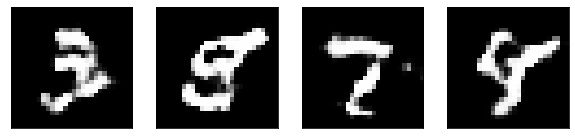

>> Images generated in epoch = 3:


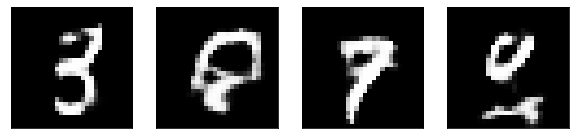

>> Images generated in epoch = 4:


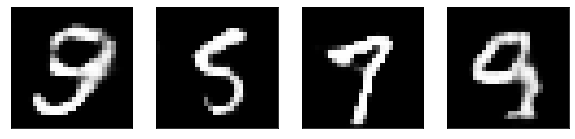

>> Images generated in epoch = 5:


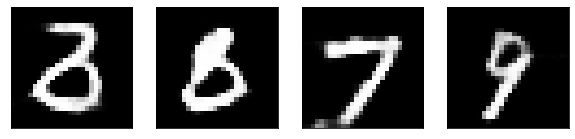

>> Images generated in epoch = 6:


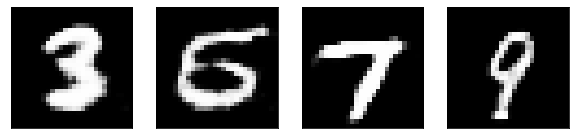

>> Images generated in epoch = 7:


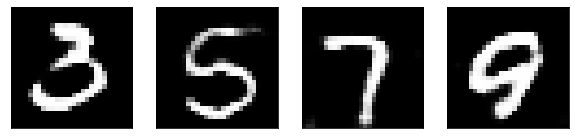

>> Images generated in epoch = 8:


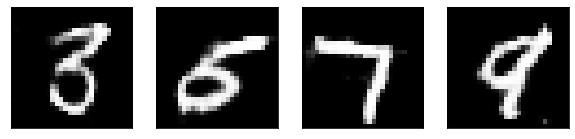

>> Images generated in epoch = 9:


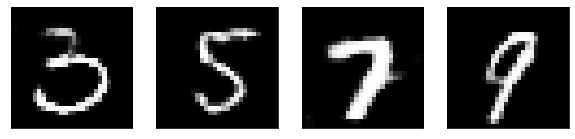

>> Images generated in epoch = 10:


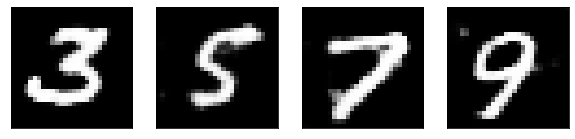

>> Images generated in epoch = 11:


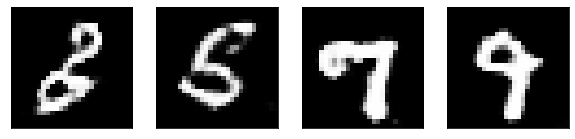

>> Images generated in epoch = 12:


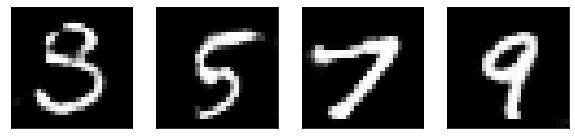

>> Images generated in epoch = 13:


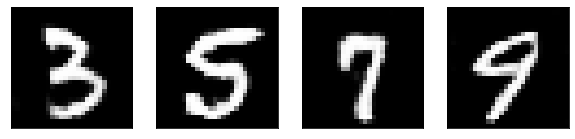

>> Images generated in epoch = 14:


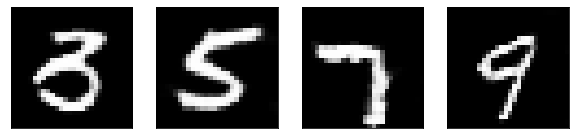

>> Images generated in epoch = 15:


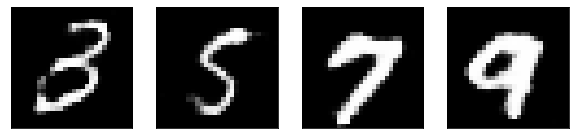

>> Images generated in epoch = 16:


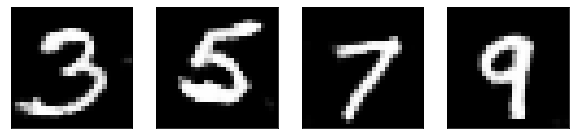

>> Images generated in epoch = 17:


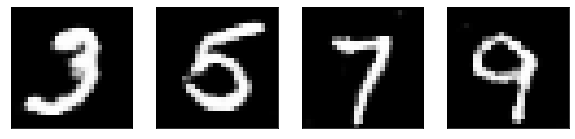

>> Images generated in epoch = 18:


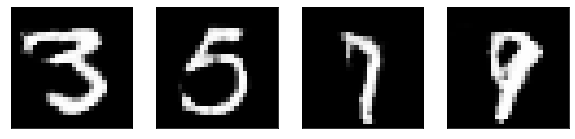

>> Images generated in epoch = 19:


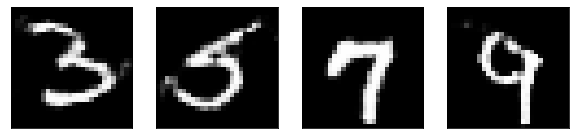

>> Images generated in epoch = 20:


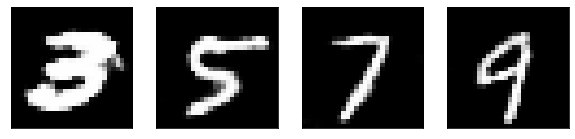

>> Images generated in epoch = 21:


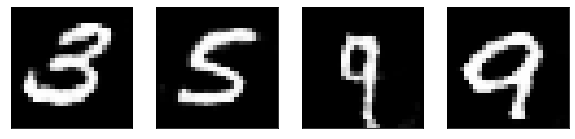

>> Images generated in epoch = 22:


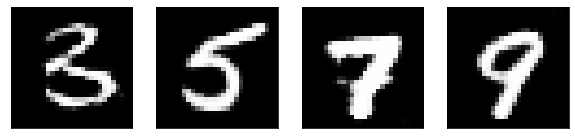

>> Images generated in epoch = 23:


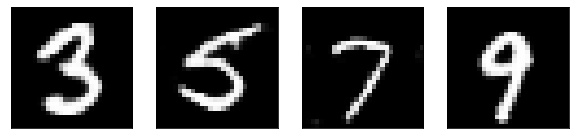

>> Images generated in epoch = 24:


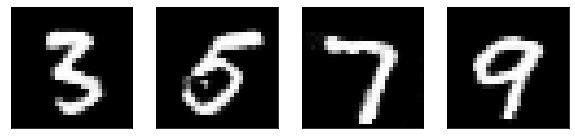

>> Images generated in epoch = 25:


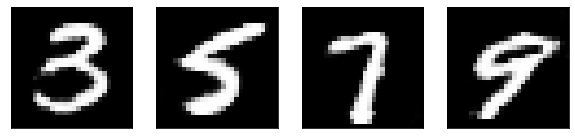

>> Images generated in epoch = 26:


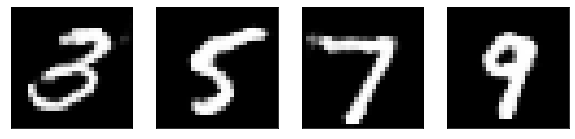

>> Images generated in epoch = 27:


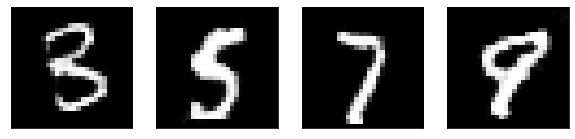

>> Images generated in epoch = 28:


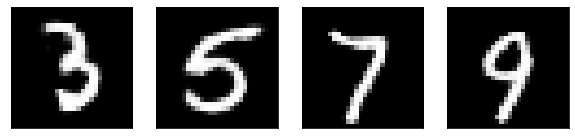

>> Images generated in epoch = 29:


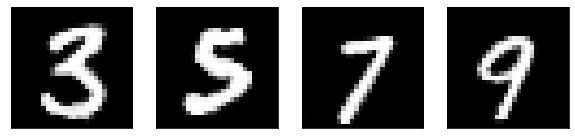

>> Images generated in epoch = 30:


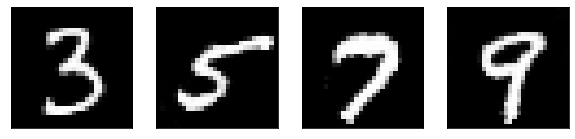

In [9]:
epochs = 30
cgan = ConditionalGAN(discriminator = discriminator, generator = generator, latent_dim = latent_dim)
cgan.compile(
    d_optimizer = keras.optimizers.Adam(learning_rate = 3e-4, beta_1 = 0.5), 
    g_optimizer = keras.optimizers.Adam(learning_rate = 3e-4, beta_1 = 0.5),
    loss_function = keras.losses.BinaryCrossentropy(),
)

history = cgan.fit(
    dataset, 
    epochs = epochs, 
    callbacks = [
        ConditionalGANMonitor(labels = (3, 5, 7, 9), latent_dim = latent_dim)
    ],
    verbose = 0
)